In [1]:
!pip install -q opendatasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import opendatasets as od
import os

# **Load and prepare a dataset for binary classification**

In [3]:
od.download_kaggle_dataset(dataset_url='https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset', data_dir='dataset')

csv_file_path = "/content/dataset/breast-cancer-dataset/breast-cancer.csv"
data = pd.read_csv(csv_file_path)

data.head()

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: joisesarakkal
Your Kaggle Key: ··········
Your Kaggle Key: ··········
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset


100%|██████████| 48.6k/48.6k [00:00<00:00, 52.2MB/s]

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Drop 'id' and 'Unnamed: 32' columns if they exist
data.drop(columns=[col for col in ['id', 'Unnamed: 32'] if col in data.columns], inplace=True)

# Convert diagnosis to binary
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

# Features and target
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Data prepared and split.")

Data prepared and split.


# **Train an SVM with linear and RBF kernel**

In [5]:
# Linear Kernel
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)
print("Linear Kernel Accuracy:", accuracy_score(y_test, svm_linear.predict(X_test)))

# RBF Kernel
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)
print("RBF Kernel Accuracy:", accuracy_score(y_test, svm_rbf.predict(X_test)))

Linear Kernel Accuracy: 0.956140350877193
RBF Kernel Accuracy: 0.9736842105263158


# **Visualize decision boundary using 2D data**

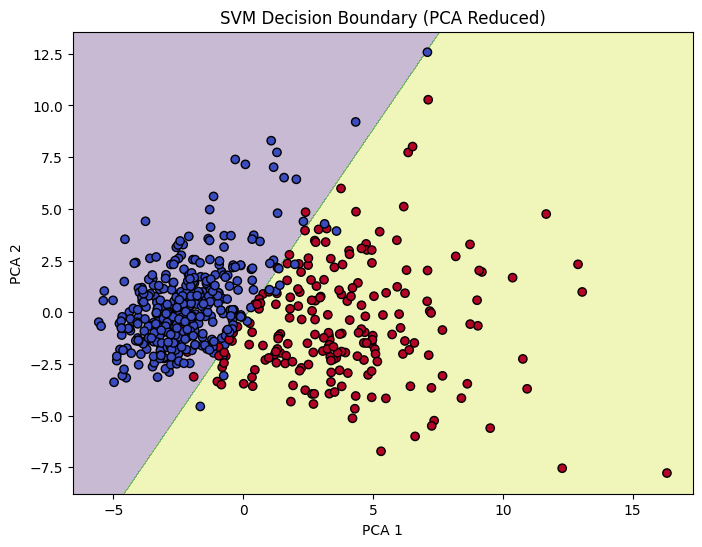

In [6]:
# 2D with PCA
# Reduce to 2 dimensions for visualization

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train SVM on 2D data
svm_2d = SVC(kernel='linear')
svm_2d.fit(X_pca, y)

# Create mesh grid for decision boundary
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
plt.title("SVM Decision Boundary (PCA Reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# **Tune hyperparameters like C and gamma**

In [7]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=5)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV Score: 0.9736263736263737


# **Use cross-validation to evaluate performance**

In [8]:
best_model = grid.best_estimator_
cv_scores = cross_val_score(best_model, X_scaled, y, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-validation scores: [0.97368421 0.97368421 0.98245614 0.97368421 0.99115044]
Mean Accuracy: 0.9789318428815401
